In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import matplotlib
import pandas as pd
import seaborn as sns
from scipy.stats import gaussian_kde
from scipy.integrate import simpson


plt.rc('font', family='serif')
plt.rc('text.latex', preamble=r'\usepackage{amsmath,bm}')
matplotlib.rcParams.update({'font.size': 16})

# matplotlib.use('TkAgg')

In [2]:
Energy = lambda t,tmax:  3.5*np.exp(-2*t/tmax)
energy_minimum = Energy(0.1,0.1) #minimum of the energy func

In [3]:
def compute_SAA_random_objective(feat):
    """
    feat = 3.5*np.exp(-2*c_times/tmax)
    or
    feat = tmax-c_times
    """
    ## now perform the averaging/quadrature
    if sampling_type in ["SAA", "random"]:
        # sample average
        res = np.mean(feat,axis=-1)
    return res


def compute_gauss_objective(feat,likelihood,quad_weights,sampling_level,ns,ntheta,nzeta,nvpar,zeta_lin,theta_lin):
    if sampling_level == "full":
        # gauss quadrature
        int0 = feat*likelihood
        int0 = int0.reshape((ns,ntheta,nzeta,nvpar))
        int0 = int0*quad_weights
        # gauss quad over vpar
        int1 = np.sum(int0,axis=-1)
        # simpson over theta,zeta
        int2 = simpson(int1,zeta_lin,axis=-1)
        int3 = simpson(int2,theta_lin,axis=-1)
        # gauss quad over s
        res = np.sum(int3)     
        
        # full gauss quad
        #res = np.sum(int0)

    else:
        # gauss quadrature
        int0 = feat*likelihood
        int0 = int0.reshape((ntheta,nzeta,nvpar))
        int0 = int0*quad_weights
        # gauss quad over vpar
        int1 = np.sum(int0,axis=-1)
        # simpson over theta,zeta
        int2 = simpson(int1,zeta_lin,axis=-1)
        res = simpson(int2,theta_lin,axis=-1)  
        
#         res = np.sum(int0)

    return res
        
def compute_simpson_objective(feat,likelihood,sampling_level,ns,ntheta,nzeta,nvpar,vpar_lin,zeta_lin,theta_lin,s_lin=[]):
    if sampling_level == "full":
        # simpson
        int0 = feat*likelihood
        int0 = int0.reshape((ns,ntheta,nzeta,nvpar))
        int1 = simpson(int0,vpar_lin,axis=-1)
        int2 = simpson(int1,zeta_lin,axis=-1)
        int3 = simpson(int2,theta_lin,axis=-1)
        res = simpson(int3,s_lin,axis=-1)
    else:
        # simpson
        int0 = feat*likelihood
        int0 = int0.reshape((ntheta,nzeta,nvpar))
        int1 = simpson(int0,vpar_lin,axis=-1)
        int2 = simpson(int1,zeta_lin,axis=-1)
        res = simpson(int2,theta_lin,axis=-1)
    return res

def compute_objective(feat, **kwargs):
    n_directions = kwargs['n_directions']
    n_points_per = kwargs['n_points_per']
    sampling_type = kwargs['sampling_type']
    sampling_level = kwargs['sampling_level']

    if sampling_type in ['SAA','random']:
        EX = compute_SAA_random_objective(feat)
        
    elif sampling_type == "gauss":
        likelihood = kwargs['likelihood']
        quad_weights = kwargs['quad_weights']
        ns = kwargs['ns']
        ntheta = kwargs['ntheta']
        nzeta = kwargs['nzeta']
        nvpar = kwargs['nvpar']
        zeta_lin = kwargs['zeta_lin']        
        theta_lin = kwargs['theta_lin']
        
        EX = np.zeros((n_directions,n_points_per))
        for ii in range(n_directions):
            for jj in range(n_points_per):
                EX[ii,jj] = compute_gauss_objective(feat[ii,jj],likelihood,quad_weights,sampling_level,ns,ntheta,nzeta,nvpar,zeta_lin,theta_lin)

    elif sampling_type == "simpson":
        likelihood = kwargs['likelihood']
        quad_weights = kwargs['quad_weights']
        ns = kwargs['ns']
        ntheta = kwargs['ntheta']
        nzeta = kwargs['nzeta']
        nvpar = kwargs['nvpar']        
        vpar_lin = kwargs['vpar_lin']        
        zeta_lin = kwargs['zeta_lin']        
        theta_lin = kwargs['theta_lin']
        if sampling_level == "full":
            s_lin = kwargs['s_lin'] 
        else:
            s_lin = []

        EX = np.zeros((n_directions,n_points_per))
        for ii in range(n_directions):
            for jj in range(n_points_per):
                EX[ii,jj] = compute_simpson_objective(feat[ii,jj],likelihood,sampling_level,ns,ntheta,nzeta,nvpar,vpar_lin,zeta_lin,theta_lin,s_lin)
    return EX

# 1d plots for a single sampling

In [ ]:
sampling_type='simpson'
s_label = 0.25
tmax = 0.0001
ns=10

data_dir = f"./_batch_{sampling_type}_tmax_{tmax}_surf_{s_label}_ns_{ns}"
infile = data_dir + f"/data_surface_{sampling_type}_{s_label}_tmax_{tmax}_ns_{ns}.pickle"
indata = pickle.load(open(infile,'rb'))

# load data for plotting
T = indata['T']
FX = indata['FX']
n_directions = indata['n_directions']
tmax = indata['tmax']

        
# set sim failures to inf
FX[~np.isfinite(FX)] = np.inf

feat = Energy(FX,tmax)
EX = compute_objective(feat,**indata)


plt.figure(figsize = (10,8))
colors = cm.jet(np.linspace(0, 1, n_directions))
for ii in range(n_directions):
  plt.plot(T,EX[ii],'-s',markersize=0,linewidth=2,color=colors[ii],label=f'dir {ii}')
plt.ylabel('energy deposited')
plt.xlabel('distance from x0')
plt.xscale('symlog', linthresh=1e-1)
# plt.yscale('log')
# plt.ylim(3.49,3.50)
plt.title("mean energy retained")
plt.legend()
plt.show()


# 1d plots for 4 different objectives

In [ ]:
sampling_type_list = ['SAA','random','simpson','gauss']
s_label = 0.25
tmax = 0.0001
ns=10


# make subplots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,sharex='col',sharey='all',figsize=(10,10))
ax = [ax1,ax2,ax3,ax4]
colors = cm.jet(np.linspace(0, 1, n_directions))


for ii,sampling_type in enumerate(sampling_type_list):

    data_dir = f"./_batch_{sampling_type}_tmax_{tmax}_surf_{s_label}_ns_{ns}"
    infile = data_dir + f"/data_surface_{sampling_type}_{s_label}_tmax_{tmax}_ns_{ns}.pickle"
    indata = pickle.load(open(infile,'rb'))
    
    # load necessary data for plotting
    T = indata['T']
    FX = indata['FX']
    n_directions = indata['n_directions']
    tmax = indata['tmax']
    sampling_level = indata['sampling_level']

        
    # set sim failures to inf
    FX[~np.isfinite(FX)] = np.inf

    feat = Energy(FX,tmax)
    EX = compute_objective(feat,**indata)

    for dd in range(n_directions):
        ax[ii].plot(T,EX[dd],'-s',markersize=0,linewidth=2,color=colors[dd],label=f'dir {dd}')
        ax[ii].grid(color='grey', linestyle='--', linewidth=1)
        
    ax[ii].set_title(sampling_type)

# plot labels
ax1.set_ylabel('$E(w)$')
ax4.set_xlabel('$||w-w_0||$')
ax3.set_ylabel('$E(w)$')
ax3.set_xlabel('$||w-w_0||$')

# 1d plot for 4 objectives along a single direction

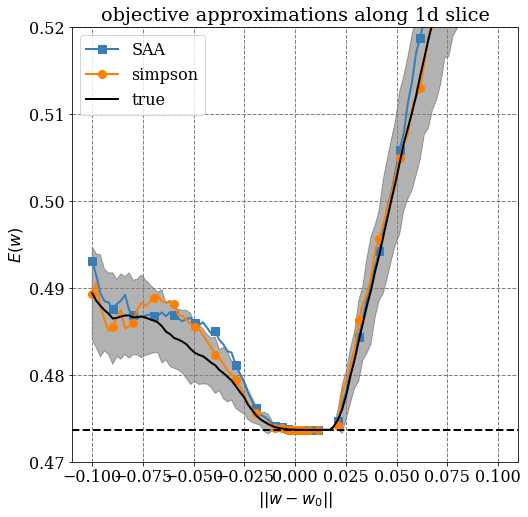

In [4]:
sampling_type_list = ['SAA','simpson']
s_label = 0.25
tmax = 0.0001
ns=13

# only use one direction
idx_dir = 2

# make subplots
fig,ax = plt.subplots(figsize=(8,8))
# colorblind colors
colors = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']
markers = ['s','o','^','x']


"""
Plot curves at the low resolution
"""
for ii,sampling_type in enumerate(sampling_type_list):

    data_dir = f"./_batch_{sampling_type}_tmax_{tmax}_surf_{s_label}_ns_{ns}"
    infile = data_dir + f"/data_surface_{sampling_type}_{s_label}_tmax_{tmax}_ns_{ns}.pickle"
    indata = pickle.load(open(infile,'rb'))
    T = indata['T']
    FX = indata['FX']
    tmax = indata['tmax']


    # set sim failures to inf
    FX[~np.isfinite(FX)] = np.inf

    feat = Energy(FX,tmax)
    EX = compute_objective(feat,**indata)
    plt.plot(T,EX[idx_dir],marker=markers[ii],markersize=8,markevery=5,linewidth=2,color=colors[ii],label=sampling_type)
    plt.grid(color='grey', linestyle='--', linewidth=1)

    

"""
Compute the standard error from 'random' at the low resolution
"""    
sampling_type = 'random'
data_dir = f"./_batch_{sampling_type}_tmax_{tmax}_surf_{s_label}_ns_{ns}"
infile = data_dir + f"/data_surface_{sampling_type}_{s_label}_tmax_{tmax}_ns_{ns}.pickle"
indata = pickle.load(open(infile,'rb'))
T = indata['T']
FX = indata['FX']
tmax = indata['tmax']


# set sim failures to inf
FX[~np.isfinite(FX)] = np.inf

feat = Energy(FX,tmax)
EX = compute_objective(feat,**indata)

# 95% confidence interval: 1.96*sigma/sqrt(n)
n_particles = FX.shape[-1]
std_errs = 1.96*np.std(feat[idx_dir],axis=1)/np.sqrt(n_particles)


"""
Now plot the highest resolution curve along with the confidence intervals from random at the low resolution
"""
sampling_type = 'SAA'
ns = 25
data_dir = f"./_batch_{sampling_type}_tmax_{tmax}_surf_{s_label}_ns_{ns}"
infile = data_dir + f"/data_surface_{sampling_type}_{s_label}_tmax_{tmax}_ns_{ns}.pickle"
indata = pickle.load(open(infile,'rb'))
T = indata['T']
FX = indata['FX']
tmax = indata['tmax']


# set sim failures to inf
FX[~np.isfinite(FX)] = np.inf

feat = Energy(FX,tmax)
EX = compute_objective(feat,**indata)

# confidence intervals
plt.fill_between(T,EX[idx_dir] + std_errs,EX[idx_dir]-std_errs,alpha=0.3,color='k')

plt.plot(T,EX[idx_dir],marker=markers[ii],markersize=0,markevery=7,linestyle='-',linewidth=2,color='k',label="true")
plt.grid(color='grey', linestyle='--', linewidth=1)
        

# draw a line at the 0% loss fraction
ax.axhline(y=energy_minimum,color='k',linestyle='--',linewidth=2)
    
plt.title("objective approximations along 1d slice")        
plt.ylabel('$E(w)$')
plt.xlabel('$||w-w_0||$')
# plt.xlim(-0.05,0.05)
plt.ylim(0.47,0.52)
plt.legend(loc='upper left')


# Convergence of objectives

For each of the four objectives, plot the objective value across the discretization levels

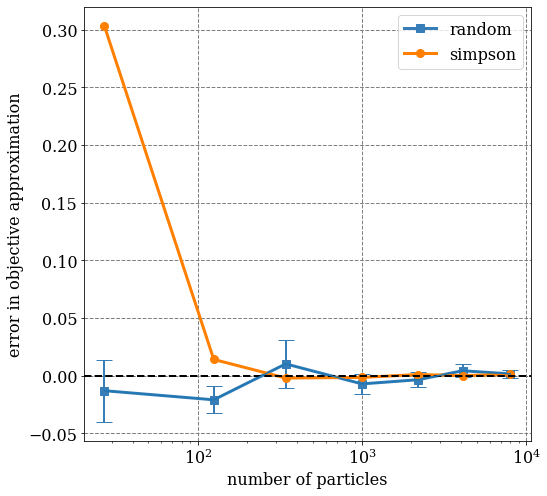

In [6]:
sampling_type_list = ['random','simpson']
s_label = 0.25
tmax = 0.0001
ns_list = [3,5,7,10,13,16,20]

# idx of the direction/point to view
idx_dir = 0
idx_point = 180

# make subplots
fig = plt.figure(figsize=(8,8))
# colors = cm.jet(np.linspace(0, 1, len(sampling_type_list)))
# colorblind colors
colors = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']
markers = ['s','o','^','x']

# storage
func_vals = np.zeros((len(sampling_type_list),len(ns_list)))
std_errs = np.zeros(len(ns_list))
n_particles = np.zeros((len(sampling_type_list),len(ns_list)))

for ii,sampling_type in enumerate(sampling_type_list):
    for jj, ns in enumerate(ns_list):

        # load the data
        data_dir = f"./_batch_{sampling_type}_tmax_{tmax}_surf_{s_label}_ns_{ns}"
        infile = data_dir + f"/data_surface_{sampling_type}_{s_label}_tmax_{tmax}_ns_{ns}.pickle"
        try:
            indata = pickle.load(open(infile,'rb'))
        except:
            # just to catch points that have not been computed
            func_vals[ii,jj] = np.inf
            n_particles[ii,jj] = np.inf
        T = indata['T']
        FX = indata['FX']
        tmax = indata['tmax']
        
        # set sim failures to inf
        FX[~np.isfinite(FX)] = np.inf
        
        # compute the objective
        feat = Energy(FX,tmax)
        EX = compute_objective(feat,**indata)
        
        # only keep the objective at one point
        func_vals[ii,jj] = EX[idx_dir,idx_point]
        
        # number of particles
        n_particles[ii,jj] = FX.shape[-1]
        
        # standard errors for random
        if sampling_type == "random":
            # 95% confidence interval: 1.96*sigma/sqrt(n)
            std_errs[jj] = 1.96*np.std(feat[idx_dir,idx_point])/np.sqrt(FX.shape[-1])

            
            
"""
Get the highest resolution curve we have
"""

ns = 25
sampling_type = "SAA"
# load the data
data_dir = f"./_batch_{sampling_type}_tmax_{tmax}_surf_{s_label}_ns_{ns}"
infile = data_dir + f"/data_surface_{sampling_type}_{s_label}_tmax_{tmax}_ns_{ns}.pickle"
try:
    indata = pickle.load(open(infile,'rb'))
except:
    # just to catch points that have not been computed
    func_vals[ii,jj] = np.inf
    n_particles[ii,jj] = np.inf
T = indata['T']
FX = indata['FX']
tmax = indata['tmax']

# set sim failures to inf
FX[~np.isfinite(FX)] = np.inf
# compute the objective
feat = Energy(FX,tmax)
EX = compute_objective(feat,**indata)
# only keep the objective at one point
true_val = EX[idx_dir,idx_point]



"""
Now plot the results
"""
            
# plot          
for ii,sampling_type in enumerate(sampling_type_list):
    if sampling_type == "random":
        plt.errorbar(n_particles[ii],func_vals[ii]-true_val,yerr=std_errs,ecolor=colors[ii],elinewidth=2,capsize=8)
    plt.plot(n_particles[ii],func_vals[ii]-true_val,marker=markers[ii],markersize=8,linewidth=3,color=colors[ii],label=sampling_type)

    
plt.grid(color='grey', linestyle='--', linewidth=1)

plt.axhline(y=0,linestyle='--',color='k',alpha=1,linewidth=2)
plt.xlabel('number of particles')
plt.ylabel('error in objective approximation')
plt.legend(loc='upper right')
plt.xscale('log')
# plt.yscale('symlog',linthresh=1e-3)

